In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
from PIL import Image

# source: https://github.com/cjmcgill/characterizing_uncertainty_scripts/blob/main/figure_scripts/figure_8.py
from multiprocessing import Pool, cpu_count

def compute_interval(args):
    upper, unce, pred, true = args
    ctr = 0
    for u, p, t in zip(unce, pred, true):
        s = np.sqrt(u)
        i = stats.norm.interval(confidence=upper, loc=p, scale=s)
        if t >= i[0] and t <= i[1]:
            ctr += 1
    return ctr

def compute_auce(pred, unce, true, q=10, num_processes=None):
    if num_processes is None:
        num_processes = cpu_count()  # Use all available CPUs if not specified

    calibration_x = [0]
    calibration_y = [0]
    calibration_y_oracle = [0]
    auce = 0

    # Prepare arguments for each process
    args = [( (i+1)*1/q, unce, pred, true) for i in range(q)]

    with Pool(processes=num_processes) as pool:
        results = pool.map(compute_interval, args)

    for i in range(q):
        upper = (i + 1) * 1 / q
        ctr = results[i]
        calibration_x.append(upper)
        calibration_y.append(ctr / len(unce))
        calibration_y_oracle.append(upper)
        auce += abs(ctr / len(unce) - upper) * 1 / q

    return auce, calibration_x, calibration_y, calibration_y_oracle
# def compute_auce(pred, unce, true, q=10):
#     calibration_x = [0]
#     calibration_y = [0]
#     calibration_y_oracle = [0]
#     auce = 0
#     for i in range(q):
#         upper = (i+1)*1/q
#         ctr = 0
#         for u,p,t in zip(unce,pred,true):
#             s = np.sqrt(u)
#             i = stats.norm.interval(confidence=upper, loc=p, scale=s) 
#             if t>= i[0] and t <= i[1]:
#                 ctr+=1
#         calibration_x.append(upper)
#         calibration_y.append(ctr/len(unce))
#         calibration_y_oracle.append(upper)
#         auce += abs(ctr/len(unce) - upper) * 1/q
#     return auce, calibration_x, calibration_y, calibration_y_oracle

def create_subplot_auce(system, true, pred, unce, xlabel=False, ylabel=False):
    target_name_dict = {"1syh score":"1SYH score", "4lde score":"4LDE score", "6y2f score":"6Y2F score",
                    "singlet-triplet value":"Singlet-triplet gap", "oscillator strength":"Oscillator strength", 
                    "abs_diff_vee":"Abs. diff. of VEE",
                    "activation_energy":"Activation energy", "reaction_energy":"Reaction energy"}
    auce, calibration_x, calibration_y, calibration_y_oracle = compute_auce(pred, unce, true, q=20)
    plt.plot(calibration_x,calibration_y,color='darkorange')
    plt.plot(calibration_x,calibration_y_oracle,color='gray')
    plt.fill_between(calibration_x,calibration_y,calibration_y_oracle, color='lightgray')
    plt.title(target_name_dict[system],fontsize=14)
    plt.text(0.15,0.9,"AUCE "+str(np.round(auce,4)), fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    if xlabel:
        plt.xlabel("Confidence level", fontsize=12)
    if ylabel:
        plt.ylabel("Proportion of data within\nthe confidence interval", fontsize=12)
    print(system, auce)


## Plot all auce plots in 4 x 2 subplot

singlet-triplet value 0.02283499999999999
oscillator strength 0.077905
abs_diff_vee 0.026004999999999993
1syh score 0.04495999999999999
4lde score 0.034550000000000004
6y2f score 0.014765
activation_energy 0.0431768864047345
reaction_energy 0.08584990958408682


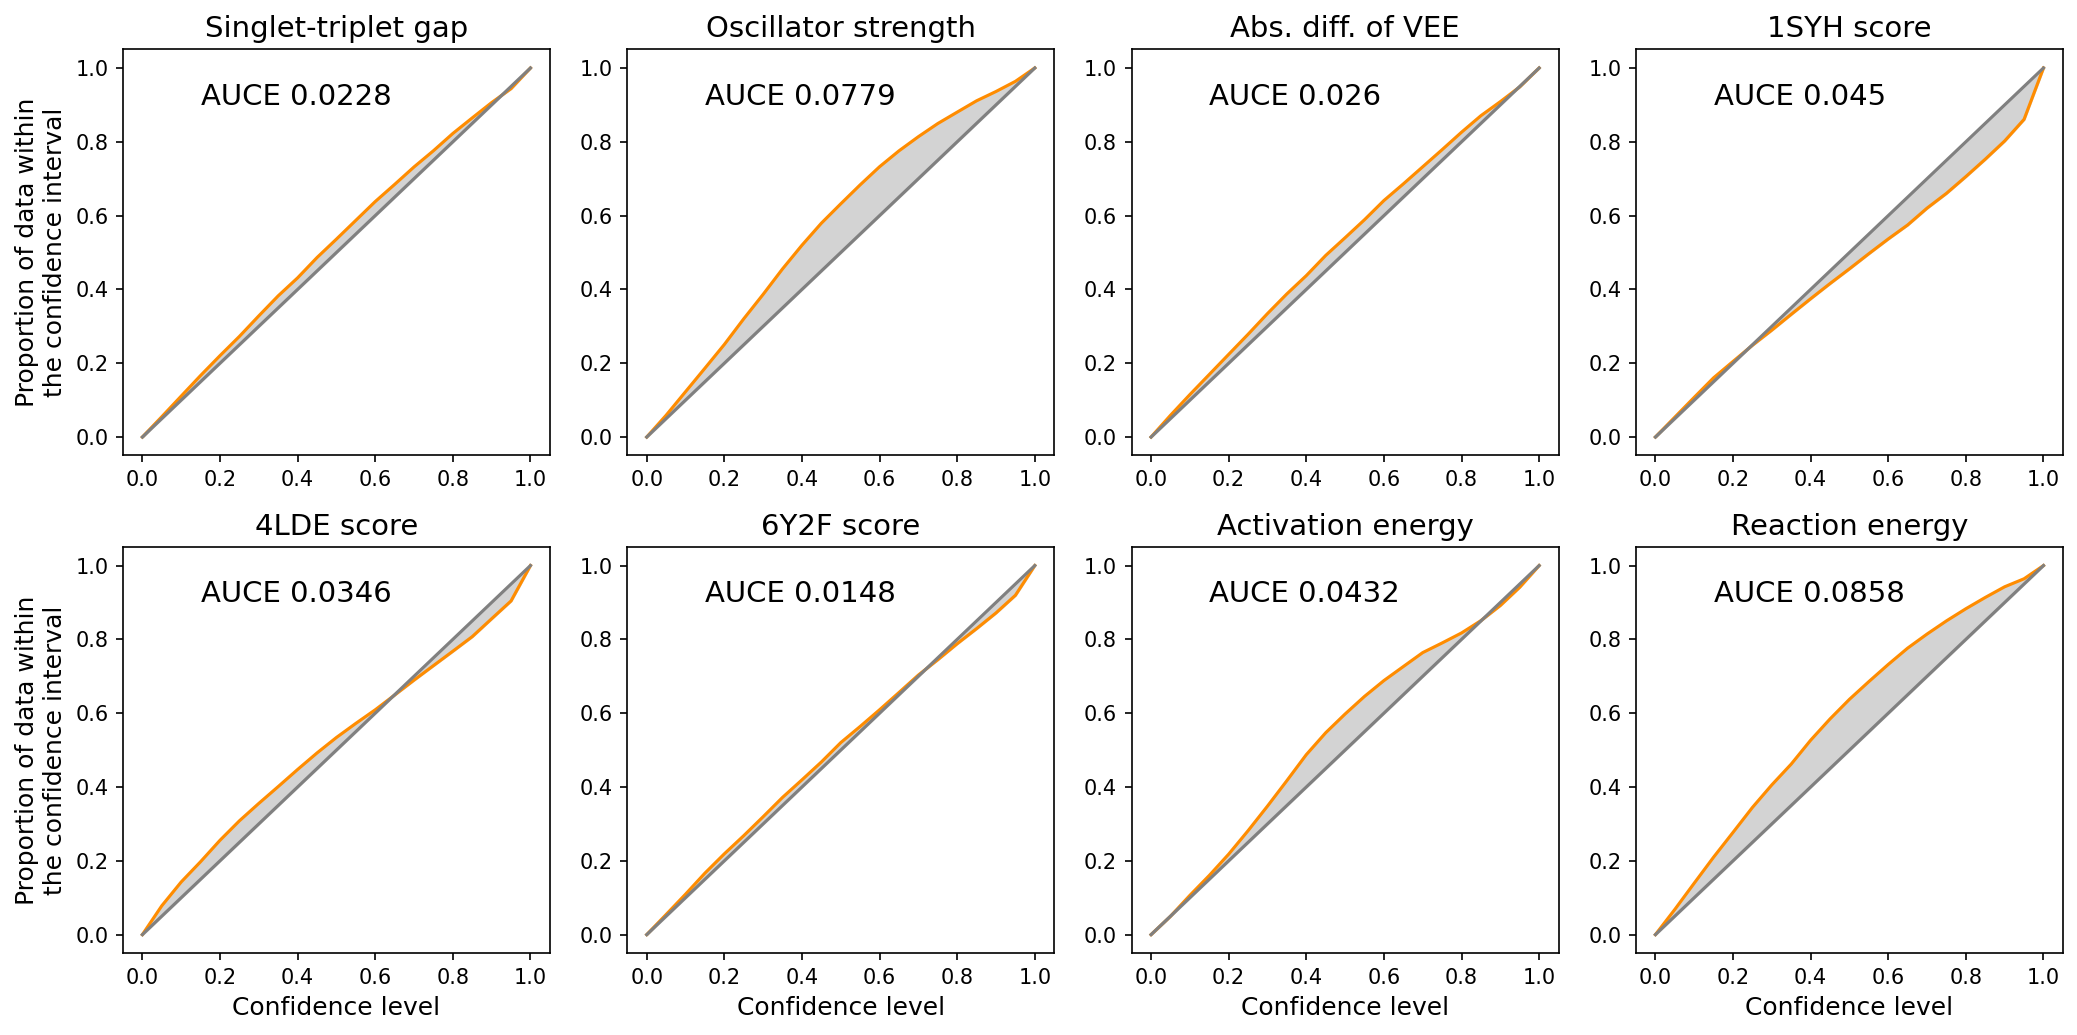

In [2]:
dataset_target = [("organic_emitter", "singlet-triplet value"), ("organic_emitter", "oscillator strength"), ("organic_emitter", "abs_diff_vee"),
                  ("docking", "1syh score"), ("docking", "4lde score"), ("docking", "6y2f score"),
                  ("reactivity", "activation_energy"), ("reactivity", "reaction_energy")]
model_dict = {"docking":"chemprop_unc/save_models/docking/evidential/fold_0",
              "organic_emitter":"chemprop_unc/save_models/organic_emitter/ensemble_mve/fold_0",
              "reactivity":"chemprop_unc/save_models/reactivity/evidential_final/fold_0"}
uncertainty_method_dict = {"docking": "evidential_total_uncal_var",
                           "organic_emitter": "mve_uncal_var",
                           "reactivity": "evidential_total_uncal_var"}

fig = plt.figure(figsize=(14,7), dpi=150)
for i, (dataset, target) in enumerate(dataset_target):
    xlabel = False
    ylabel = False

    j = i + 1
    x = i//4 + 1
    y = j%4
    if y == 0: 
        y = 4
    if x == 2:
        xlabel = True
    if y == 1:
        ylabel = True
    plt.subplot(int(str(2) + str(4) + str(j)))
    model_path = model_dict[dataset]
    uncertainty_method = uncertainty_method_dict[dataset]
    unc_name = target + "_" + uncertainty_method

    true_df = pd.read_csv(os.path.join(model_path, "test_full.csv"))
    pred_df = pd.read_csv(os.path.join(model_path, "test_unc.csv"))
    n=10000
    if dataset == "reactivity":
        n = len(true_df)
    index = true_df.sample(n, random_state=0).index

    true = true_df[target].values[index]
    pred = pred_df[target].values[index]
    unce = pred_df[unc_name].values[index]
    create_subplot_auce(target, true, pred, unce, xlabel=xlabel, ylabel=ylabel)
else:
    plt.tight_layout()
    plt.savefig("figures/auce_plots/overall_auce.svg", format="svg")

## Organic emitter design

In [4]:
# mve version
n=10000
target_columns = ["singlet-triplet value", "oscillator strength", "abs_diff_vee"]
target_path = "./chemprop_unc/save_models/organic_emitter/ensemble_mve/fold_0/test_unc.csv"
true_path = "./chemprop_unc/save_models/organic_emitter/ensemble_mve/fold_0/test_full.csv"
save_dir = "figures/auce_plots/oe_ensemble_mve_unc"
os.makedirs(save_dir, exist_ok=True)

true_df = pd.read_csv(true_path)
pred_df = pd.read_csv(target_path)
index = true_df.sample(n, random_state=0).index

singlet-triplet value 0.02283499999999999
oscillator strength 0.077905
abs_diff_vee 0.026004999999999993


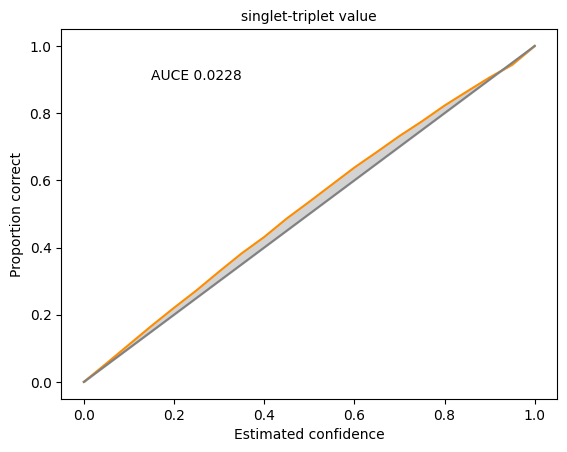

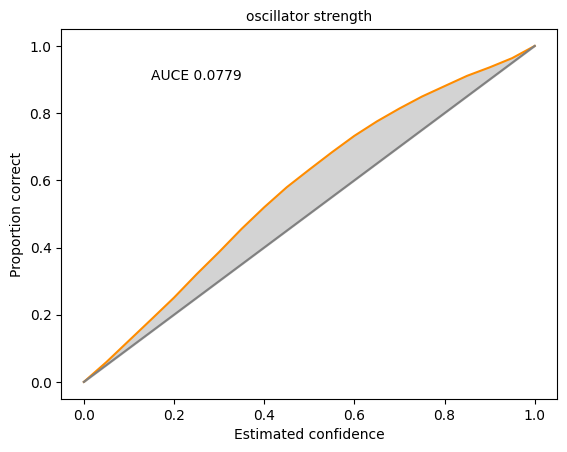

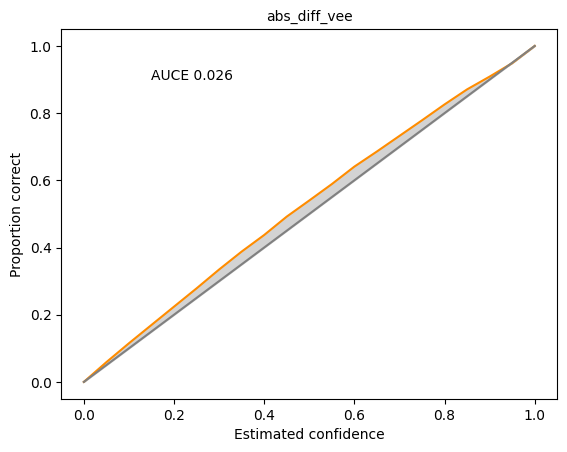

In [5]:
for system in target_columns:
    unc_name = system + "_mve_uncal_var"

    true = true_df[system].values[index]
    pred = pred_df[system].values[index]
    unce = pred_df[unc_name].values[index]

    plt.figure(dpi=100)
    auce, calibration_x, calibration_y, calibration_y_oracle = compute_auce(pred, unce, true, q=20)
    plt.plot(calibration_x,calibration_y,color='darkorange')
    plt.plot(calibration_x,calibration_y_oracle,color='gray')
    plt.fill_between(calibration_x,calibration_y,calibration_y_oracle, color='lightgray')
    plt.title(system,fontsize=10)
    plt.text(0.15,0.9,"AUCE "+str(np.round(auce,4)))
    plt.xlabel("Estimated confidence")
    plt.ylabel("Proportion correct")
    print(system, auce)
    plt.savefig(os.path.join(save_dir, system+".svg"), format='svg')

# Docking

In [6]:
target_columns = ["1syh score", "4lde score", "6y2f score"]

target_path = "./chemprop_unc/save_models/docking/evidential/fold_0/test_unc.csv"
true_path = "./chemprop_unc/save_models/docking/evidential/fold_0/test_full.csv"
save_dir = "figures/auce_plots/docking_evidential_lambda_02"
os.makedirs(save_dir, exist_ok=True)

true_df = pd.read_csv(true_path)
pred_df = pd.read_csv(target_path)

n=10000
index = true_df.sample(n, random_state=0).index


1syh score 0.04495999999999999
4lde score 0.034550000000000004
6y2f score 0.014765


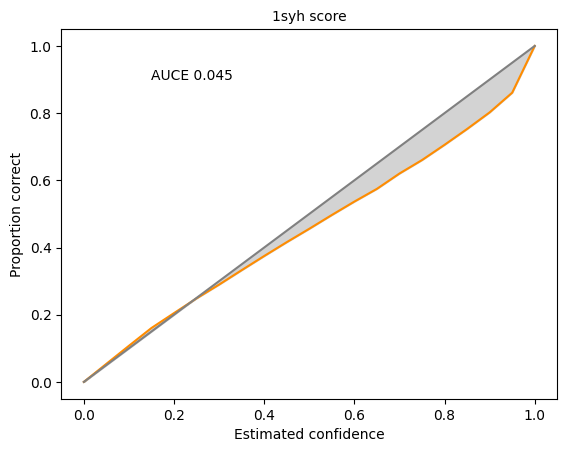

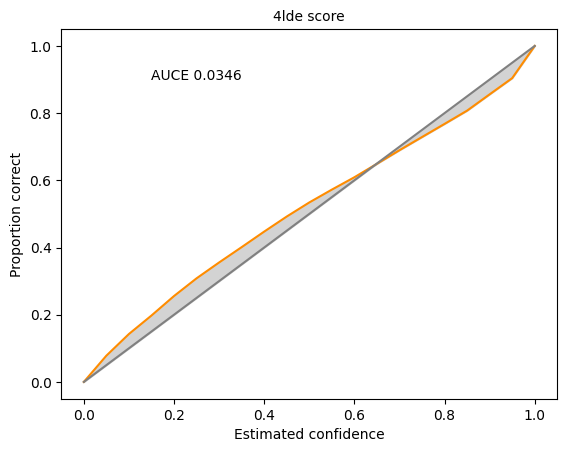

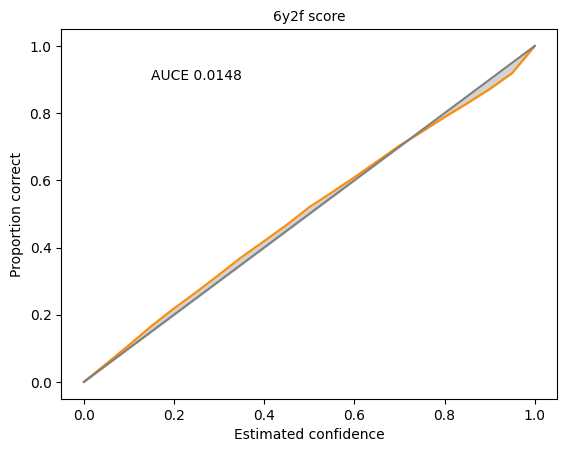

In [7]:
for system in target_columns:
    unc_name = system + "_evidential_total_uncal_var"

    true = true_df[system].values[index]
    pred = pred_df[system].values[index]
    unce = pred_df[unc_name].values[index]

    plt.figure(dpi=100)
    auce, calibration_x, calibration_y, calibration_y_oracle = compute_auce(pred, unce, true, q=20)
    plt.plot(calibration_x,calibration_y,color='darkorange')
    plt.plot(calibration_x,calibration_y_oracle,color='gray')
    plt.fill_between(calibration_x,calibration_y,calibration_y_oracle, color='lightgray')
    plt.title(system,fontsize=10)
    plt.text(0.15,0.9,"AUCE "+str(np.round(auce,4)))
    plt.xlabel("Estimated confidence")
    plt.ylabel("Proportion correct")
    print(system, auce)
    plt.savefig(os.path.join(save_dir, system+".svg"), format='svg')

### Reactivity

In [8]:
target_columns = ["activation_energy", "reaction_energy"]
dataset = "reactivity"

target_path = "./chemprop_unc/save_models/reactivity/evidential_final/fold_0/test_unc.csv"
true_path = "./chemprop_unc/save_models/reactivity/evidential_final/fold_0/test_full.csv"
save_dir = "figures/auce_plots/reactivity_evidential_reg0001_drop040_total"
os.makedirs(save_dir, exist_ok=True)

true_df = pd.read_csv(true_path)
pred_df = pd.read_csv(target_path)

# n=10000
# index = true_df.sample(n, random_state=0).index


activation_energy 0.0431768864047345
reaction_energy 0.08584990958408682


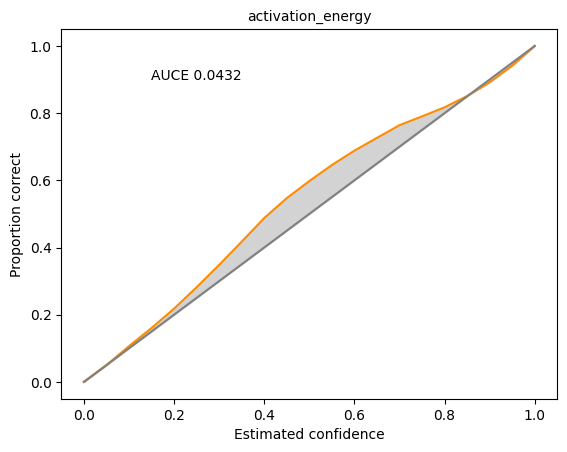

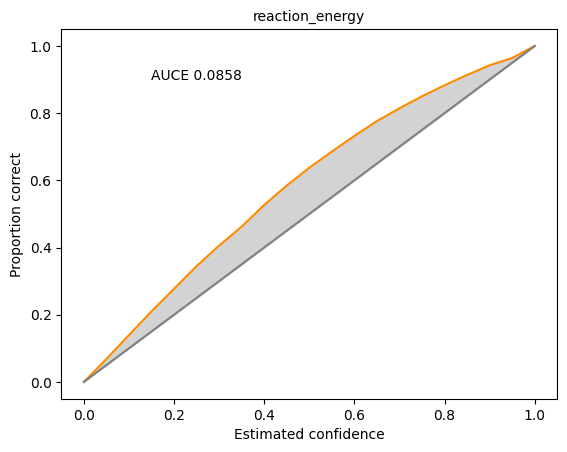

In [9]:
for system in target_columns:
    unc_name = system + "_evidential_total_uncal_var"

    true = true_df[system].values # [index]
    pred = pred_df[system].values # [index]
    unce = pred_df[unc_name].values # [index]

    plt.figure(dpi=100)
    auce, calibration_x, calibration_y, calibration_y_oracle = compute_auce(pred, unce, true, q=20)
    plt.plot(calibration_x,calibration_y,color='darkorange')
    plt.plot(calibration_x,calibration_y_oracle,color='gray')
    plt.fill_between(calibration_x,calibration_y,calibration_y_oracle, color='lightgray')
    plt.title(system,fontsize=10)
    plt.text(0.15,0.9,"AUCE "+str(np.round(auce,4)))
    plt.xlabel("Estimated confidence")
    plt.ylabel("Proportion correct")
    print(system, auce)
    plt.savefig(os.path.join(save_dir, system+".svg"), format='svg')

## Dockstring

IGF1R 0.00648793050430503
JAK2 0.03268565498154981
KIT 0.0060647703248126045
LCK 0.03280865621156213
MAPK14 0.0062636940226792285
MAPKAPK2 0.028901595233519123
MET 0.008272601476014753
PTK2 0.018396117624447438
PTPN1 0.02019026752767527
SRC 0.011188115006150063
HSD11B1 0.033608164206642074
PARP1 0.048376897943494146
PDE5A 0.010884071340713404
PTGS2 0.03932442821449164
ESR1 0.019536439114391138
ESR2 0.04465136838868388
NR3C1 0.012999231212761853
PGR 0.011815805658056585
PPARA 0.01664936961869619
PPARD 0.02903982164821648


/tmp/ipykernel_4256/765202945.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(dpi=100)


PPARG 0.03654526234864502
ADAM17 0.052196725092250915
F10 0.04840572746492408
F2 0.011175283490294065


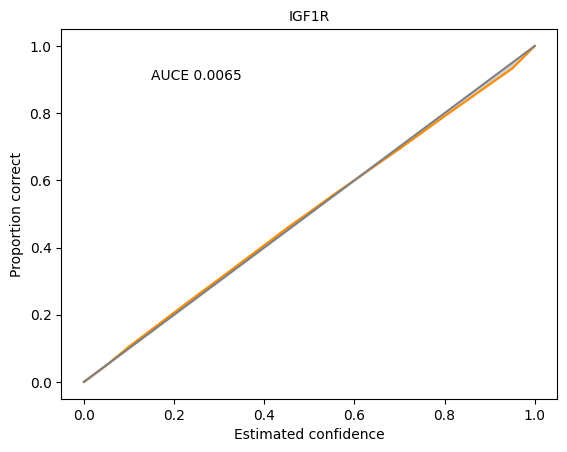

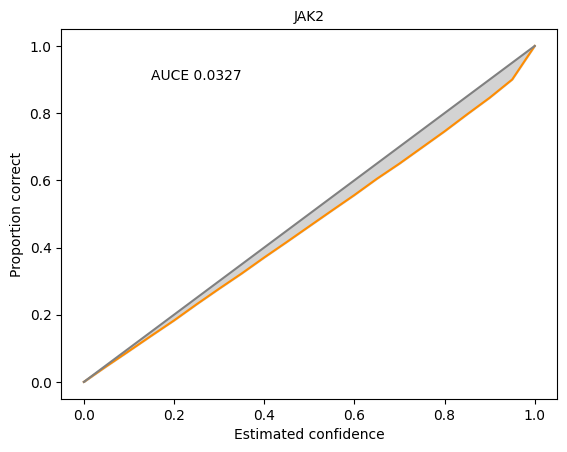

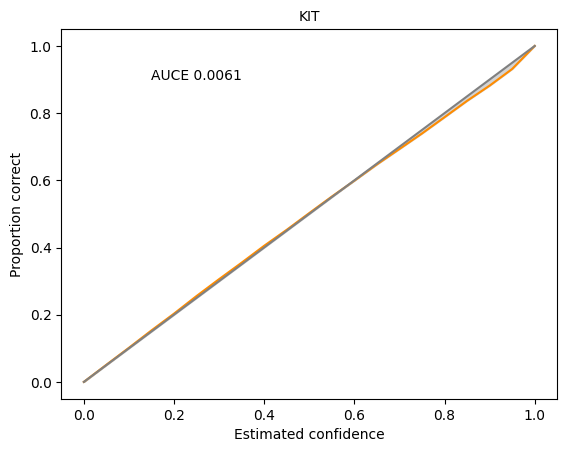

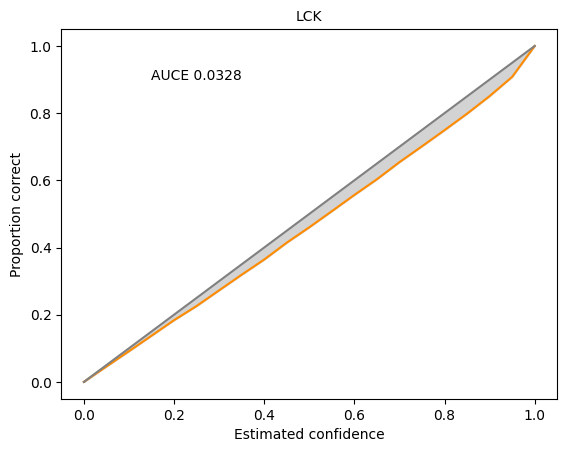

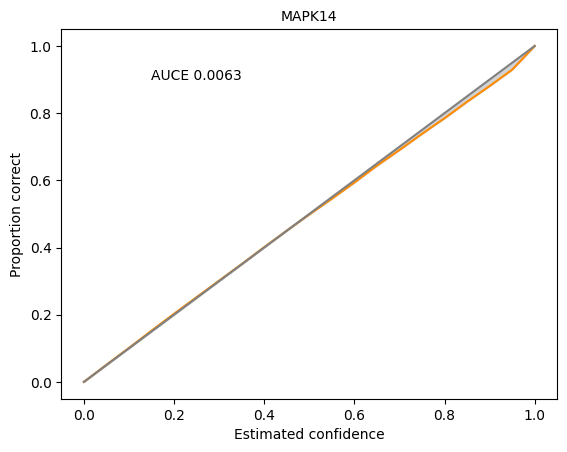

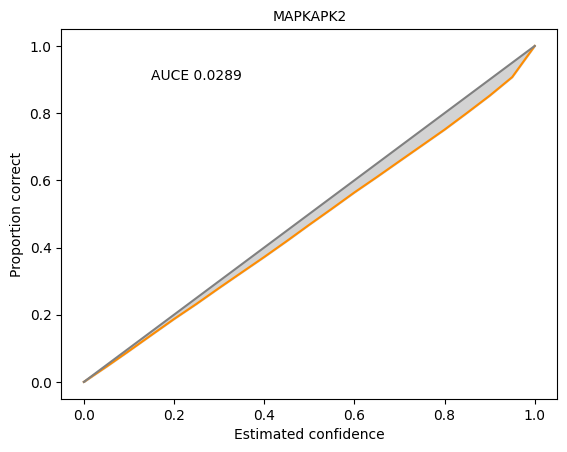

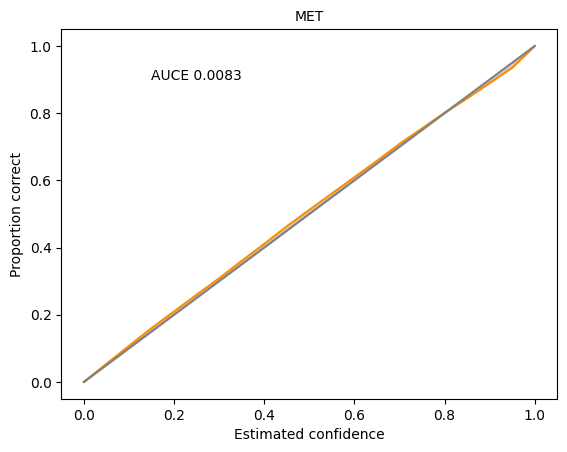

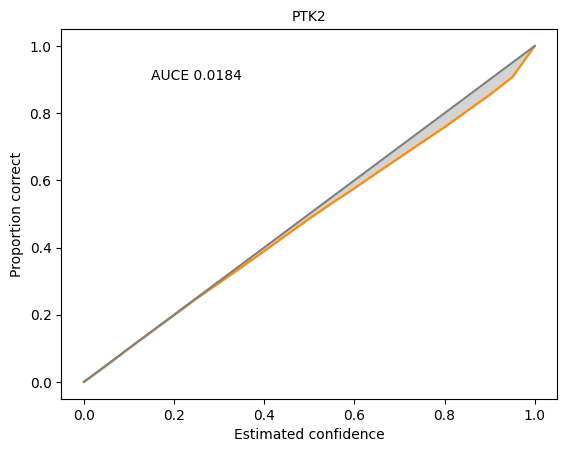

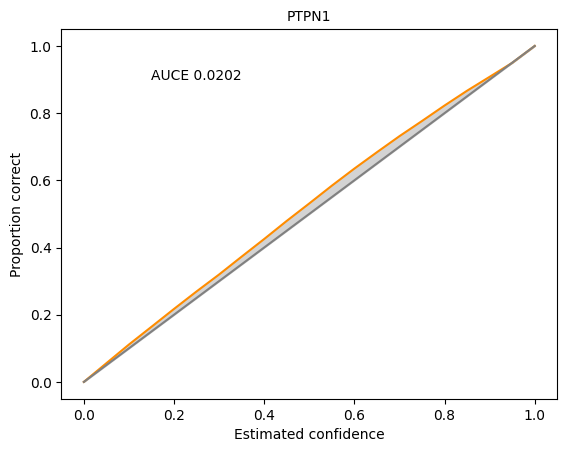

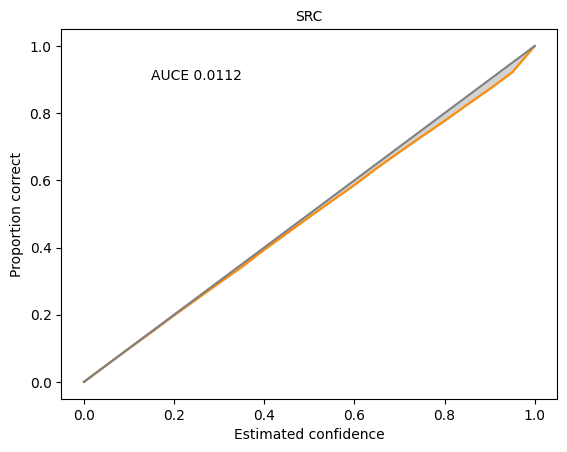

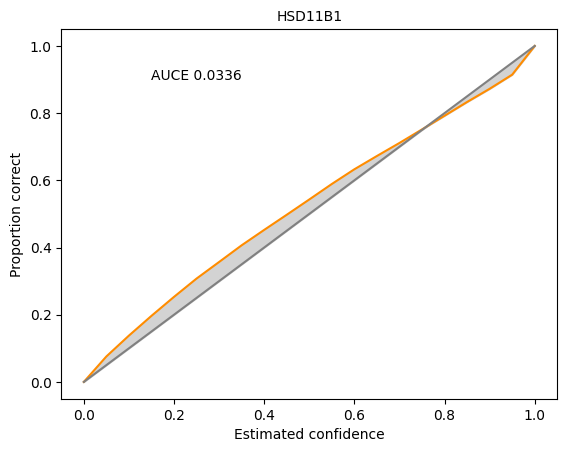

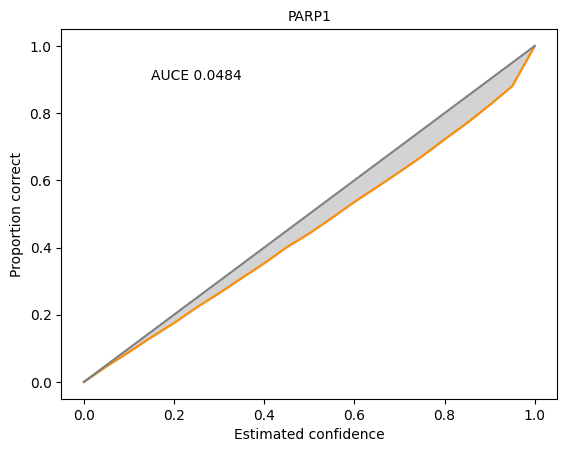

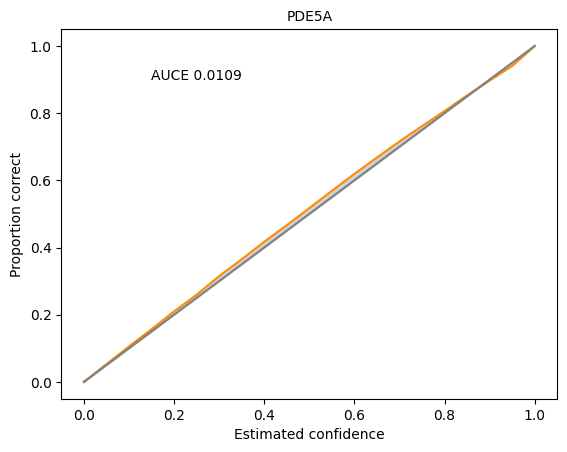

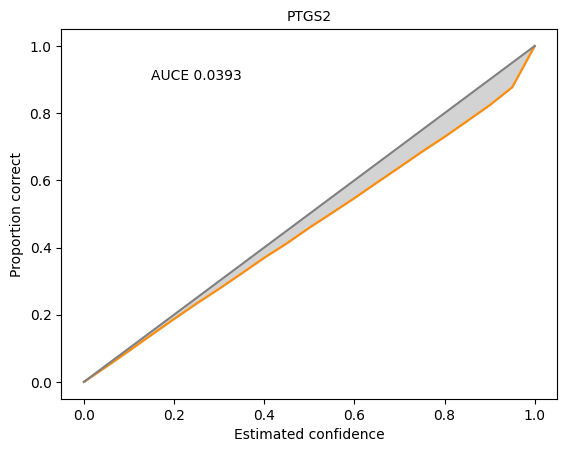

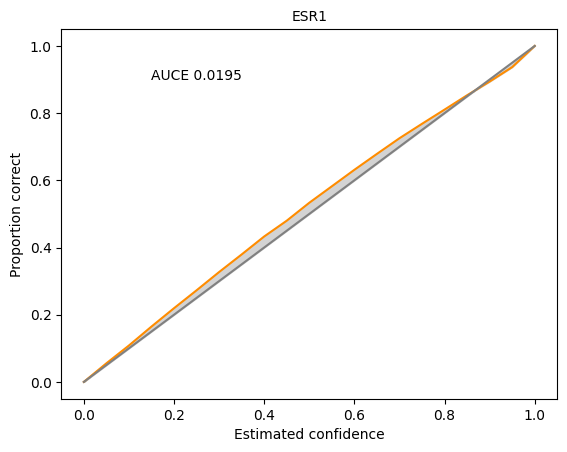

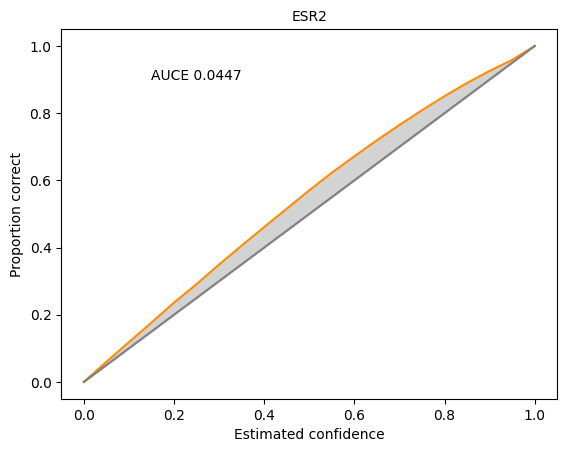

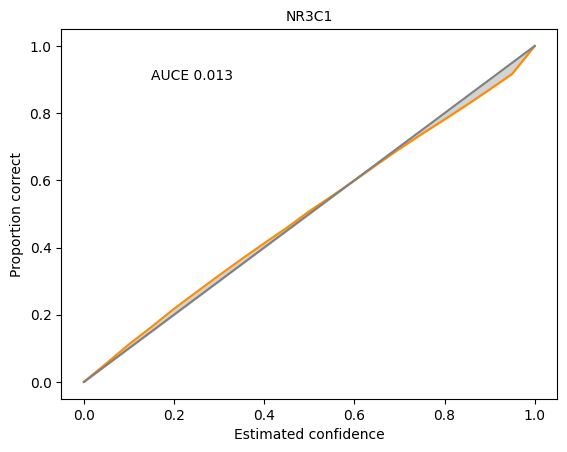

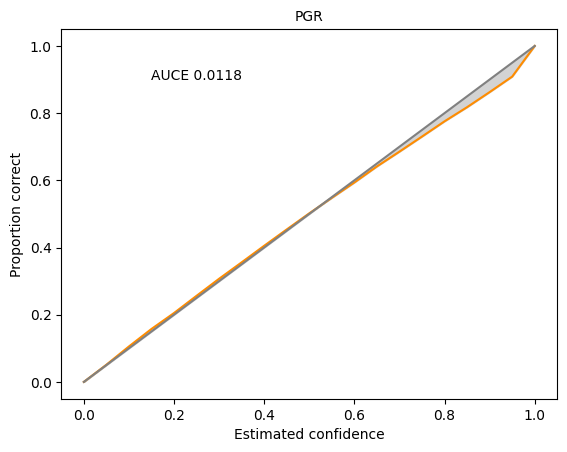

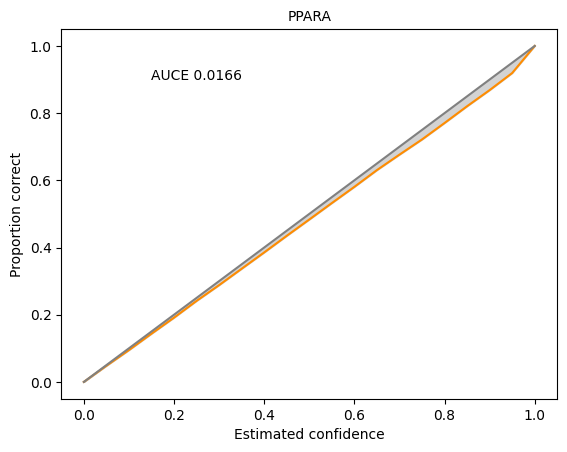

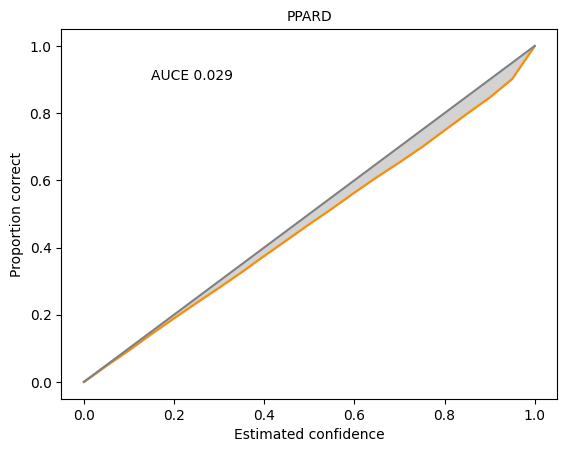

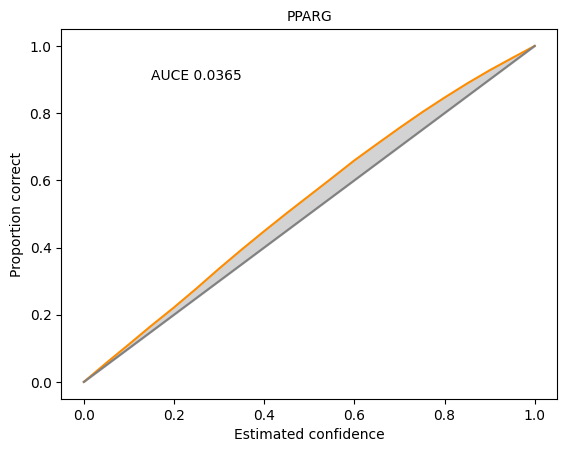

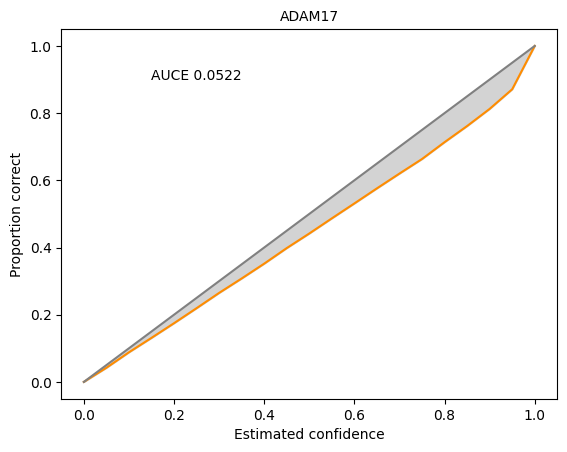

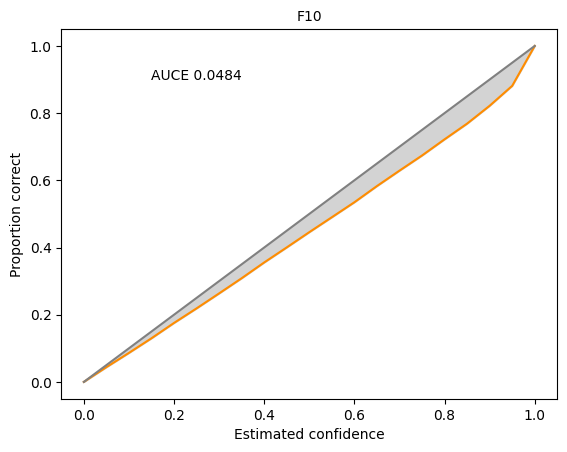

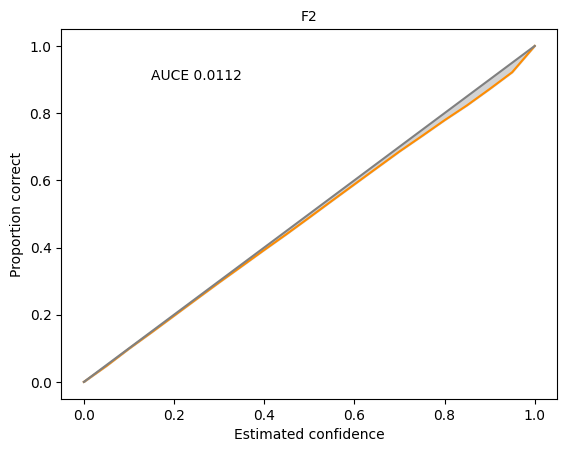

In [3]:
# high quality datasets
target_cutoffs = {'IGF1R': -12.2, 'JAK2': -13.7, 'KIT': -12.9, 'LCK': -13.6, 
                  'MAPK14': -12.8, 'MAPKAPK2': -13.1, 'MET': -13.4, 'PTK2': -13.3, 
                  'PTPN1': -12.5, 'SRC': -13.8, 'HSD11B1': -13.2, 'PARP1': -15.3, 
                  'PDE5A': -15.2, 'PTGS2': -13.9, 'ESR1': -12.9, 'ESR2': -12.3, 
                  'NR3C1': -13.3, 'PGR': -13.0, 'PPARA': -14.0, 'PPARD': -14.7, 
                  'PPARG': -13.4, 'ADAM17': -13.3, 'F10': -12.9, 'F2': -12.2}
target_columns = list(target_cutoffs.keys())
dataset = "dockstring"

for i, system in enumerate(target_columns):
    target_path = f"./chemprop_unc/save_models/{dataset}/{system}/fold_0/test_unc.csv"
    true_path = f"./chemprop_unc/save_models/{dataset}/{system}/fold_0/test_full.csv"
    save_dir = f"figures/auce_plots/{dataset}/evidential_5perc"
    os.makedirs(save_dir, exist_ok=True)

    true_df = pd.read_csv(true_path)
    pred_df = pd.read_csv(target_path)

    unc_name = system + "_evidential_total_uncal_var"

    true = true_df[system].values # [index]
    pred = pred_df[system].values # [index]
    unce = pred_df[unc_name].values # [index]

    plt.figure(dpi=100)
    auce, calibration_x, calibration_y, calibration_y_oracle = compute_auce(pred, unce, true, q=20)
    plt.plot(calibration_x,calibration_y,color='darkorange')
    plt.plot(calibration_x,calibration_y_oracle,color='gray')
    plt.fill_between(calibration_x,calibration_y,calibration_y_oracle, color='lightgray')
    plt.title(system,fontsize=10)
    plt.text(0.15,0.9,"AUCE "+str(np.round(auce,4)))
    plt.xlabel("Estimated confidence")
    plt.ylabel("Proportion correct")
    print(system, auce)
    plt.savefig(os.path.join(save_dir, str(i+1).zfill(2)+"_"+system+".svg"), format='svg')

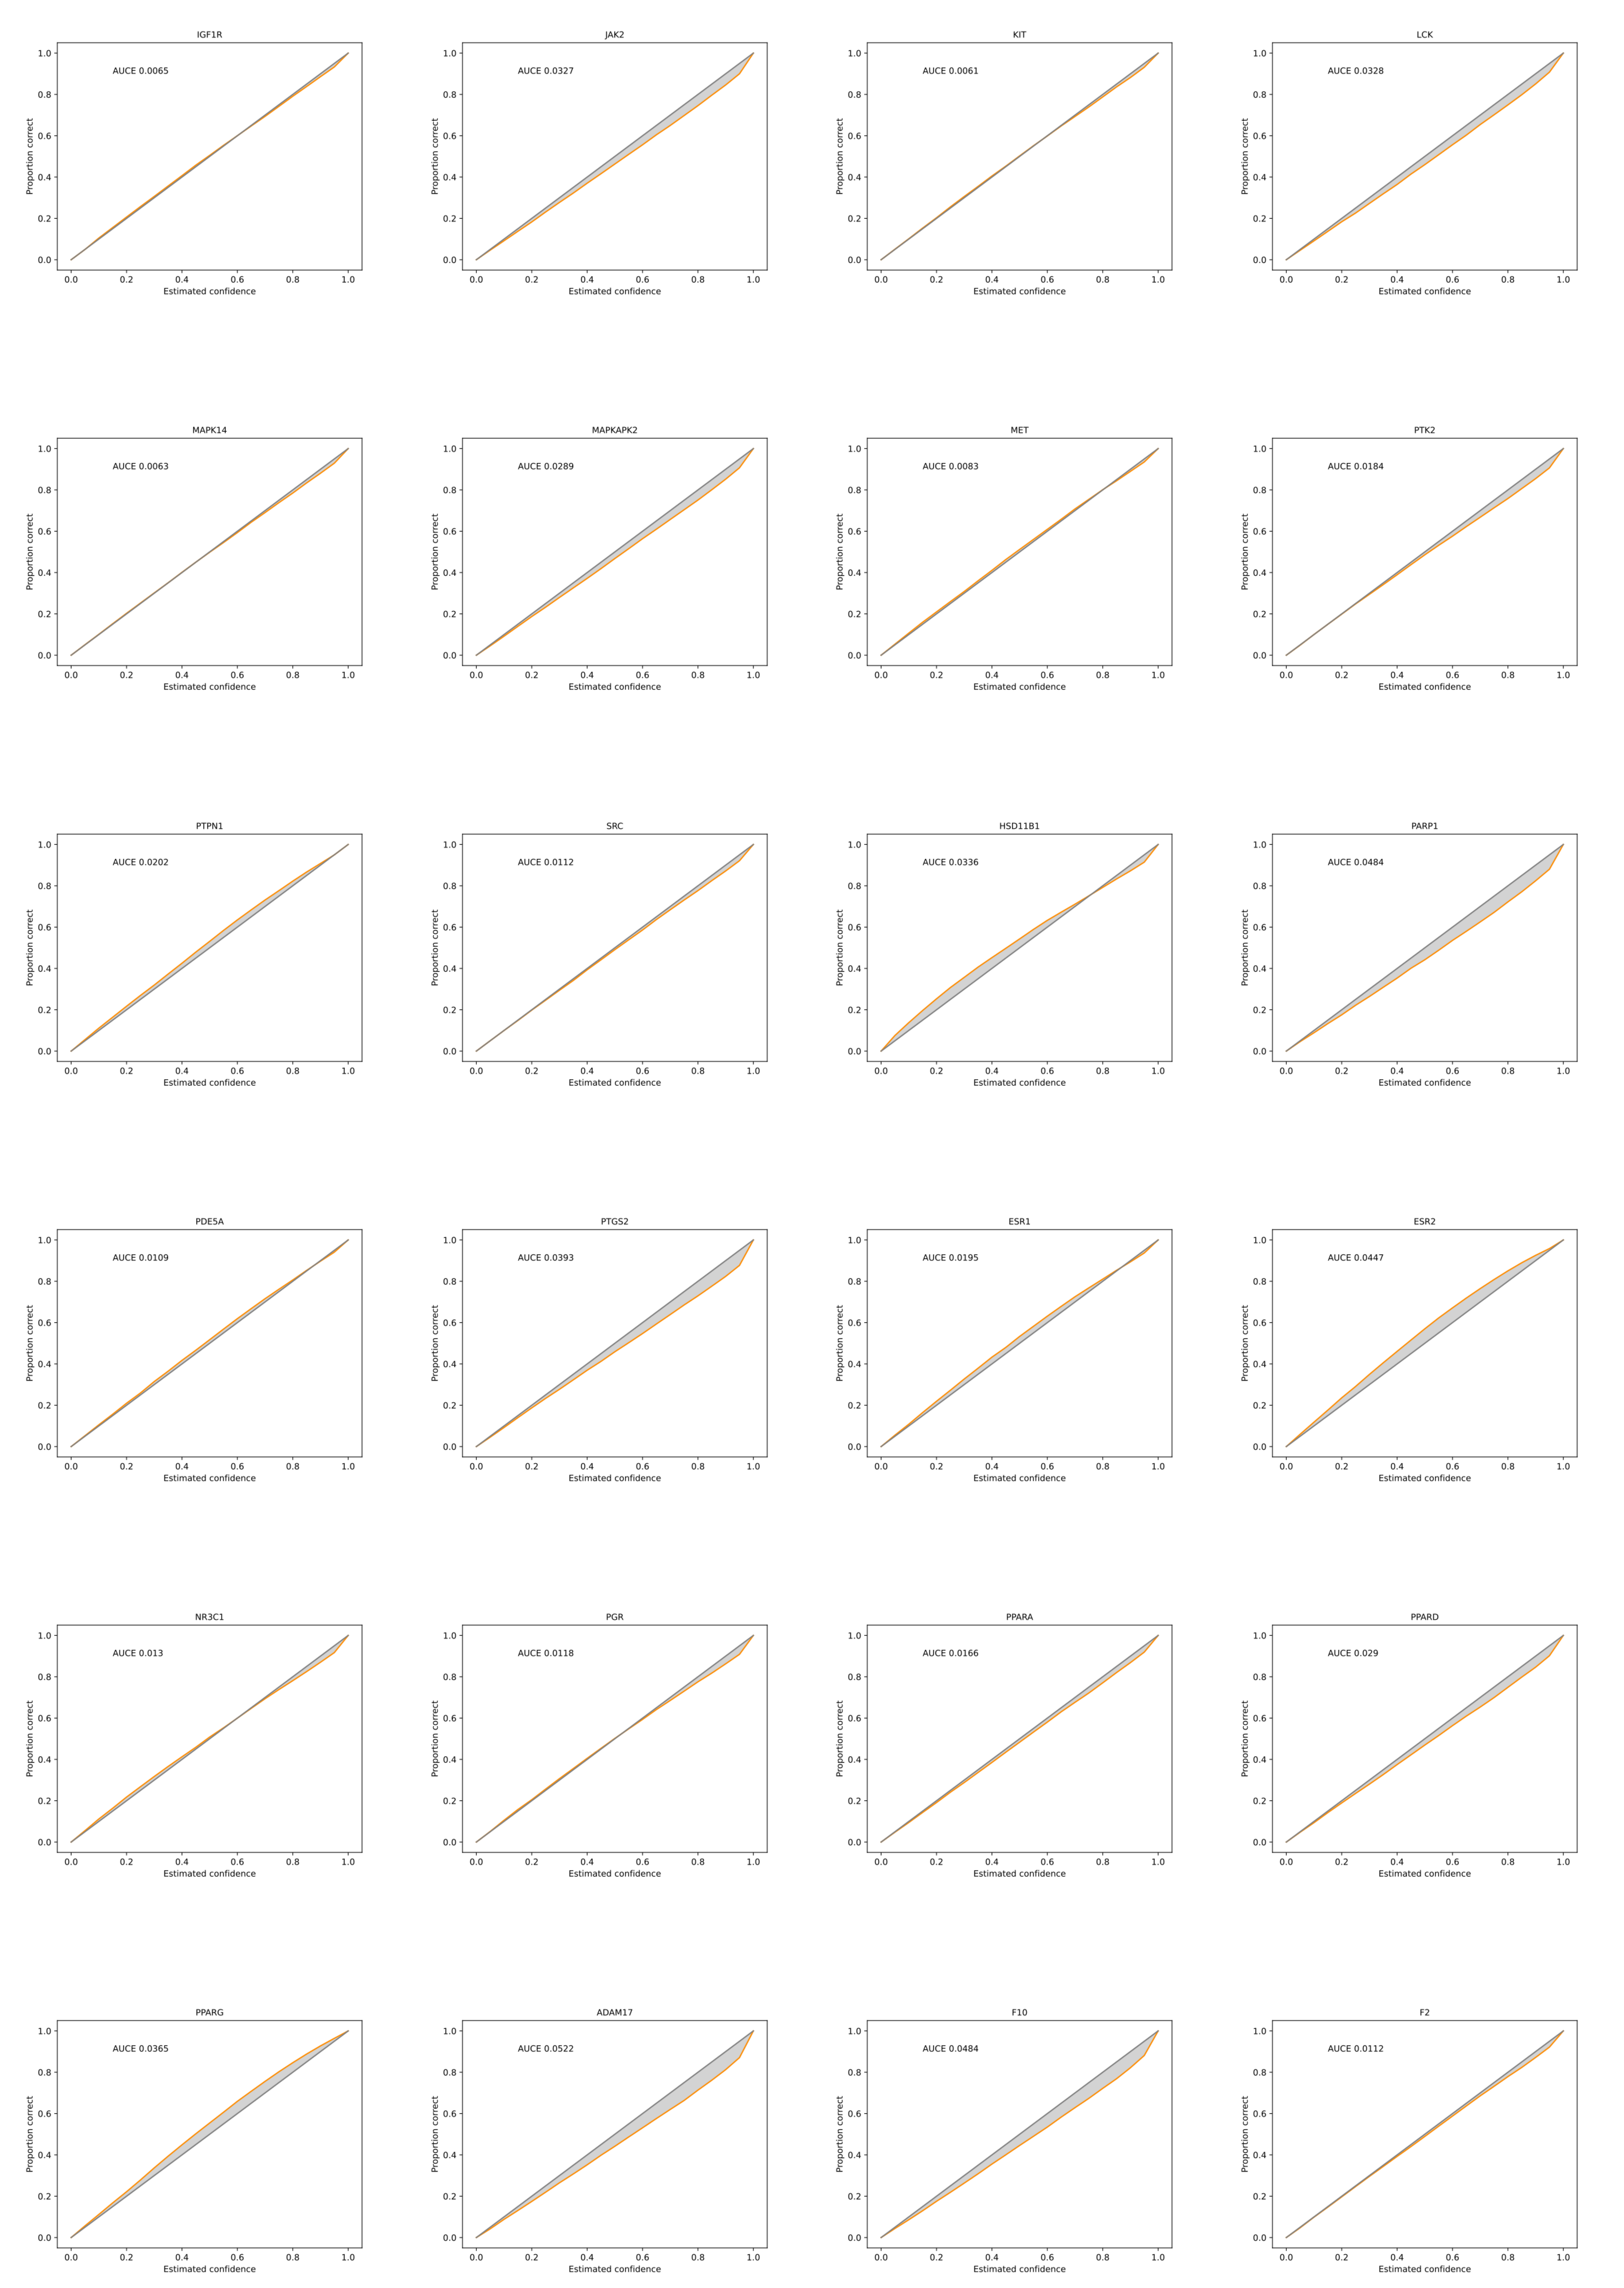

In [7]:
import io
import cairosvg
# high quality datasets
target_cutoffs = {'IGF1R': -12.2, 'JAK2': -13.7, 'KIT': -12.9, 'LCK': -13.6, 
                  'MAPK14': -12.8, 'MAPKAPK2': -13.1, 'MET': -13.4, 'PTK2': -13.3, 
                  'PTPN1': -12.5, 'SRC': -13.8, 'HSD11B1': -13.2, 'PARP1': -15.3, 
                  'PDE5A': -15.2, 'PTGS2': -13.9, 'ESR1': -12.9, 'ESR2': -12.3, 
                  'NR3C1': -13.3, 'PGR': -13.0, 'PPARA': -14.0, 'PPARD': -14.7, 
                  'PPARG': -13.4, 'ADAM17': -13.3, 'F10': -12.9, 'F2': -12.2}
target_columns = list(target_cutoffs.keys())
dataset = "dockstring"
image_files = [f"figures/auce_plots/{dataset}/evidential_5perc/{str(i+1).zfill(2)}_{target}.svg" for i, target in enumerate(target_columns)]

labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l','m','n','o','p','q','r','s','t','u','v','w','x',]

fig, axs = plt.subplots(6, 4, figsize=(20, 30), dpi=200) 

for i, ax in enumerate(axs.flat):
    image_path = image_files[i]
    if os.path.exists(image_path):
        with open(image_path, 'rb') as svg_file:
            svg_data = svg_file.read()
            png_data = cairosvg.svg2png(bytestring=svg_data)
            img = Image.open(io.BytesIO(png_data))

    else:
        continue 

    ax.imshow(img)
    ax.axis('off')
    # ax.text(0, 0, labels[i], color='black', fontsize=24, va='top', ha='left', weight="bold")

plt.tight_layout()
plt.savefig('figures/auce_plots/dockstring/evidential_5perc/combined_images.svg', format="svg")
plt.show()
